!pip install ultralytics

!pip install deep-sort-realtime

!pip install helper

!pip install torch torchvision torchaudio

In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:41:10_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [2]:
import torch
torch.cuda.is_available()

True

In [2]:
import datetime
from ultralytics import YOLO
import cv2
import pyvirtualcam
import math
import numpy as np
from KalmanFilter import KalmanFilter

# define some constants
CONFIDENCE_THRESHOLD = 0.6
GREEN = (0, 255, 0)
w_fhd = int(1920/2)
h_fhd = int(1080/2)
w_hd=int(1280/2)
h_hd=int(720/2)

KF = KalmanFilter(0.1, 1, 1, 5, 20, 20)

# initialize the video capture object
video_cap = cv2.VideoCapture("Videos/test1.mp4")

# Video from BGR to RGB
fmt = pyvirtualcam.PixelFormat.BGR
# load the pre-trained YOLOv8n model
#model = YOLO("yolov8n.pt")
model = YOLO("yolov8n-pose.pt")
model.to('cuda')

In [3]:
f_total = 0
f_segm = 0
debugging = True
testing = True
movement_threshold = 0

In [4]:
def bounds(x, y, relative_w, relative_h, real_w, real_h):
    xmin = 0
    xmax = 0
    ymin = 0
    ymax = 0
    if x < relative_w:
        xmin = 0
        xmax = relative_w*2
    elif x > (real_w-relative_w):
        xmin = real_w-(relative_w*2)
        xmax = real_w
    else:
        xmin = int(x-relative_w)
        xmax = int(x+relative_w)
    
    if y < relative_h:
        ymin = 0
        ymax = relative_h*2
    elif y > (real_h-relative_h):
        ymin = real_h-(relative_h*2)
        ymax = real_h
    else:
        ymin = int(y-relative_h)
        ymax = int(y+relative_h)
    return xmin, xmax, ymin, ymax

In [10]:
centroidX = 0
centroidY = 0
keyPoints = [0, 5, 6]
(x1, y1) = KF.update([w_fhd, h_fhd])
with pyvirtualcam.Camera(width=1920, height=1080, fps=30, fmt=fmt) as cam:
    while True:
        # Fotograma vacio
        frameProcessed = np.zeros((cam.height, cam.width, 3), np.uint8)
        
        # Inicio de tiempo para medir
        start = datetime.datetime.now()
    
        # Captura de video
        ret, frame = video_cap.read()

        # Si no hay más frames, se cierra el bucle
        if not ret:
            break
        
        # Se corre YOLO
        detections = model(frame, 
                           classes=0, 
                           conf=CONFIDENCE_THRESHOLD, 
                           verbose=False)[0].keypoints.data.tolist()
        
        temp_centroidX = 0
        temp_centroidY = 0
        distanceCenter = 0
        
        for data in detections:
            for i in keyPoints:
                temp_centroidX = temp_centroidX + data[i][0]
                temp_centroidY = temp_centroidY + data[i][1]
                cv2.circle(frame, (int(data[i][0]), int(data[i][1])), radius=5, color=(255, 0, 0), thickness=-1)
            temp_centroidX = temp_centroidX/3
            temp_centroidY = temp_centroidY/3
            temp_distanceCenter = np.sqrt((temp_centroidX-w_fhd)**2+(temp_centroidY-h_fhd)**2)
            if distanceCenter == 0:
                distanceCenter = temp_distanceCenter
                centroidX = int(temp_centroidX)
                centroidY = int(temp_centroidY)
            elif temp_distanceCenter < distanceCenter:
                distanceCenter = temp_distanceCenter
                centroidX = int(temp_centroidX)
                centroidY = int(temp_centroidY)
                
        #print(centroidX, centroidY)
        focus = np.asarray(KF.predict()[0]).reshape(-1)
        if debugging:
            cv2.circle(frame, (centroidX, centroidY), radius=5, color=(0, 0, 255), thickness=-1)
            cv2.circle(frame, (int(focus[0]), int(focus[1])), radius=5, color=(0, 255, 0), thickness=-1)
        
        (x1, y1) = KF.update([centroidX, centroidY])
        # Calculo del enfoque 
        xmin_p, xmax_p, ymin_p, ymax_p = bounds(int(focus[0]), int(focus[1]), w_hd, h_hd, 1920, 1080)
        frame = frame[ymin_p:ymax_p, xmin_p:xmax_p]

        # Aumentado del tamaño
        frame = cv2.resize(frame, (1920, 1080))
        
        if debugging:           
            # end time to compute the fps
            end = datetime.datetime.now()
            # show the time it took to process 1 frame
            total = (end - start).total_seconds()
            #print(f"Time to process 1 frame: {total * 1000:.0f} milliseconds")

            # calculate the frame per second and draw it on the frame
            fps = f"FPS: {1 / total:.2f}"
            cv2.putText(frame, fps, (50, 50),
                        cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 8)

        cam.send(frame)
        cam.sleep_until_next_frame()

    video_cap.release()

In [8]:
centroidX = 0
centroidY = 0
x = np.asarray(KF.predict()[0]).reshape(-1)
(x1, y1) = KF.update([w_fhd, h_fhd])

with pyvirtualcam.Camera(width=1920, height=1080, fps=30, fmt=fmt) as cam:
    while True:
        # Fotograma vacio
        frameProcessed = np.zeros((cam.height, cam.width, 3), np.uint8)
        
        # Inicio de tiempo para medir
        start = datetime.datetime.now()
    
        # Captura de video
        ret, frame = video_cap.read()

        # Si no hay más frames, se cierra el bucle
        if not ret:
            break
        
        # Se corre YOLO
        # class 0 = persons
        detections = model(frame, classes=0, conf=CONFIDENCE_THRESHOLD, verbose=False)[0].boxes.data.tolist()
        
        if testing:
            # Suma total de fotogramas del video
            f_total = f_total+1
            if len(detections) > 0:
                # Suma de fotogramas segmentados
                f_segm = f_segm+1            
        
        n_detections = len(detections)
        
        temp_centroidX = 0
        temp_centroidY = 0
        for data in detections:            
            # Coordenadas iniciales y finales
            xmin, ymin, xmax, ymax = int(data[0]), int(data[1]), int(data[2]), int(data[3])
            
            # Calculo del punto a enfocar
            xcenter = round(xmin+(xmax-xmin)/2)
            ycenter = round(ymin+(ymax-ymin)/3)
            
            temp_centroidX = temp_centroidX + xcenter
            temp_centroidY = temp_centroidY + ycenter
             
            if debugging:
                # Dibujo del rectangulo
                cv2.rectangle(frame, (xmin, ymin) , (xmax, ymax), GREEN, 2)

                # Dibujo punto de focus
                cv2.circle(frame, (xcenter, ycenter), radius=5, color=(0, 0, 255), thickness=-1)
                
        if  temp_centroidX != 0 and temp_centroidY != 0:
            centroidX = temp_centroidX/n_detections
            centroidY = temp_centroidY/n_detections
                
        focus = np.asarray(KF.predict()[0]).reshape(-1)
        if debugging:
            cv2.circle(frame, (int(focus[0]), int(focus[1])), radius=5, color=(0, 255, 0), thickness=-1)
        
        (x1, y1) = KF.update([centroidX, centroidY])
        
        
        # Calculo del enfoque 
        xmin_p, xmax_p, ymin_p, ymax_p = bounds(int(focus[0]), int(focus[1]), w_hd, h_hd, 1920, 1080)
        frame = frame[ymin_p:ymax_p, xmin_p:xmax_p]

        # Aumentado del tamaño
        frame = cv2.resize(frame, (1920, 1080))
            
        if debugging:           
            # end time to compute the fps
            end = datetime.datetime.now()
            # show the time it took to process 1 frame
            total = (end - start).total_seconds()
            #print(f"Time to process 1 frame: {total * 1000:.0f} milliseconds")

            # calculate the frame per second and draw it on the frame
            fps = f"FPS: {1 / total:.2f}"
            cv2.putText(frame, fps, (50, 50),
                        cv2.FONT_HERSHEY_SIMPLEX, 2, (0, 0, 255), 8)

        cam.send(frame)
        cam.sleep_until_next_frame()

    video_cap.release()

KeyboardInterrupt: 

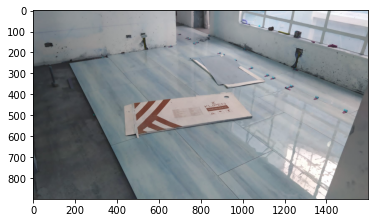

In [35]:
img = cv2.imread("test.jpeg", cv2.IMREAD_ANYCOLOR)
plt.imshow(img)

In [36]:
img.shape

(900, 1600, 3)

In [37]:
with pyvirtualcam.Camera(width=1600, height=900, fps=30) as cam:
    print(f'Using virtual camera: {cam.device}')
    frame = np.zeros((cam.height, cam.width, 3), np.uint8)  # RGB
    while True:
        cam.send(img)
        cam.sleep_until_next_frame()

Using virtual camera: OBS Virtual Camera


KeyboardInterrupt: 